In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from google.cloud import bigquery

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_id = "evanalysis"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/content/drive/MyDrive/DB Sys/EV/Datasets/evanalysis-a6b6ec9c5a9d.json"


In [ ]:

# Construct a BigQuery client object.
client = bigquery.Client()

# TODO(developer): Set dataset_id to the ID of the dataset that contains
#                  the tables you are listing.
dataset_id = 'evanalysis.electric_vehicle_dataset'

tables = client.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'evanalysis.electric_vehicle_dataset':
evanalysis.electric_vehicle_dataset.Vehicle_Energy_Consumption
evanalysis.electric_vehicle_dataset.Vehicle_as_per_Year_Count
evanalysis.electric_vehicle_dataset.alt_fuelstation
evanalysis.electric_vehicle_dataset.charge_station_infra_data
evanalysis.electric_vehicle_dataset.electric_vehicle_registration
evanalysis.electric_vehicle_dataset.testtable


In [ ]:

def fetch_data(project_id, query):
    client = bigquery.Client(project=project_id)
    query_job = client.query(query)
    results = query_job.result()
    return results

In [ ]:
query = """SELECT
     evReg.Year,
     evReg.State,
     (evReg.Electric) AS Total_electric_vehicles,
     COALESCE(stations_per_year_per_state.Size_of_charging_stations, 0) AS Size_of_charging_stations, stations_per_year_per_state.num_level1_chargers as num_level1_chargers, stations_per_year_per_state.num_level2_chargers as num_level2_chargers, stations_per_year_per_state.num_level3_chargers as num_level3_chargers
 FROM evanalysis.electric_vehicle_dataset.electric_vehicle_registration evReg
 LEFT JOIN (
     SELECT
         EXTRACT(YEAR FROM alt_Fuel.Open_Data) AS year,
         alt_Fuel.State,
         COUNT(*) AS Size_of_charging_stations, SUM(EV_Level1_EVSE_Num) as num_level1_chargers, SUM(EV_Level2_EVSE_Num) as num_level2_chargers, SUM(EV_DC_Fast_Count) as num_level3_chargers
     FROM evanalysis.electric_vehicle_dataset.alt_fuelstation alt_Fuel
     GROUP BY year, State)
      AS stations_per_year_per_state
 ON evReg.Year = stations_per_year_per_state.year
    AND evReg.State = stations_per_year_per_state.State ORDER BY evReg.State, evReg.Year"""


results = fetch_data(project_id, query)
dataframe =  [dict(row) for row in results]
df_1 = pd.DataFrame(dataframe)
df_1

,Year,State,Total_electric_vehicles,Size_of_charging_stations,num_level1_chargers,num_level2_chargers,num_level3_chargers
0,2016,Alabama,500,2,None,3,None
1,2017,Alabama,800,3,None,4,None
2,2018,Alabama,1300,0,None,None,None
3,2019,Alabama,2000,0,None,None,None
4,2020,Alabama,2900,12,None,25,None
...,...,...,...,...,...,...,...
351,2018,Wyoming,200,0,None,None,None
352,2019,Wyoming,200,2,None,10,None
353,2020,Wyoming,300,0,None,None,None
354,2021,Wyoming,500,4,1,3,None


In [ ]:
query = """SELECT
    evReg.Year,
    evReg.State,
    SUM(evReg.Electric) OVER (PARTITION BY evReg.State ORDER BY evReg.Year)  AS Total_electric_vehicles,
    SUM(stations_per_year_per_state.Size_of_charging_stations) OVER (PARTITION BY evReg.State ORDER BY evReg.Year) AS Cumulative_Charging_Stations
FROM evanalysis.electric_vehicle_dataset.electric_vehicle_registration evReg
LEFT JOIN (
    SELECT
        EXTRACT(YEAR FROM alt_Fuel.Open_Data) AS Year,
        alt_Fuel.State,
        COUNT(*) AS Size_of_charging_stations
    FROM evanalysis.electric_vehicle_dataset.alt_fuelstation alt_Fuel
    GROUP BY Year, State
) AS stations_per_year_per_state
ON evReg.Year = stations_per_year_per_state.Year
   AND evReg.State = stations_per_year_per_state.State
ORDER BY evReg.State, evReg.Year"""


results = fetch_data(project_id, query)
dataframe =  [dict(row) for row in results]
dataframe

[{'Year': 2016,
  'State': 'Alabama',
  'Total_electric_vehicles': 500,
  'Cumulative_Charging_Stations': 2},
 {'Year': 2017,
  'State': 'Alabama',
  'Total_electric_vehicles': 1300,
  'Cumulative_Charging_Stations': 5},
 {'Year': 2018,
  'State': 'Alabama',
  'Total_electric_vehicles': 2600,
  'Cumulative_Charging_Stations': 5},
 {'Year': 2019,
  'State': 'Alabama',
  'Total_electric_vehicles': 4600,
  'Cumulative_Charging_Stations': 5},
 {'Year': 2020,
  'State': 'Alabama',
  'Total_electric_vehicles': 7500,
  'Cumulative_Charging_Stations': 17},
 {'Year': 2021,
  'State': 'Alabama',
  'Total_electric_vehicles': 12200,
  'Cumulative_Charging_Stations': 24},
 {'Year': 2022,
  'State': 'Alabama',
  'Total_electric_vehicles': 20900,
  'Cumulative_Charging_Stations': 39},
 {'Year': 2016,
  'State': 'Alaska',
  'Total_electric_vehicles': 200,
  'Cumulative_Charging_Stations': None},
 {'Year': 2017,
  'State': 'Alaska',
  'Total_electric_vehicles': 600,
  'Cumulative_Charging_Stations': 3}

In [ ]:
# -- Convert 'Open Date' column to datetime if needed
# SELECT
#     *,
#     CAST(`Open Date` AS DATETIME) AS `Open Date`
# FROM df_charging_stations_per_state;

# -- Extract year from 'Open Date' column and add it as a new column
# SELECT
#     *,
#     YEAR(CAST(`Open Date` AS DATETIME)) AS `Year`
# FROM df_charging_stations_per_state;

# -- Group by 'Year' and 'State' and count the number of stations per year and per state
# SELECT
#     `Year`,
#     `State`,
#     COUNT(*) AS `Size_of_charging_stations`,
# FROM df_charging_stations_per_state
# GROUP BY `Year`, `State`;

# -- Group by 'Year' and 'State' and calculate the size of charging stations
# SELECT
#     df_vehicles_per_state.`Year`,
#     df_vehicles_per_state.`State`,
#     (df_vehicles_per_state.`Electric` + df_vehicles_per_state.`Hybrid_Electric`) AS `Total_electric`,
#     COALESCE(stations_per_year_per_state.`Size_of_charging_stations`, 0) AS `Size_of_charging_stations`
# FROM df_vehicles_per_state
# LEFT JOIN (
#     SELECT
#         `Year`,
#         `State`,
#         COUNT(*) AS `Size_of_charging_stations`
#     FROM df_charging_stations_per_state
#     GROUP BY `Year`, `State`
# ) AS stations_per_year_per_state
# ON df_vehicles_per_state.`Year` = stations_per_year_per_state.`Year`
#    AND df_vehicles_per_state.`State` = stations_per_year_per_state.`State`;

# -- Calculate the weekly capacity in miles
# SELECT
#     *,
#     (COALESCE(`EV Level1 EVSE Num`, 0) * 18 * 2) +
#     (COALESCE(`EV Level2 EVSE Num`, 0) * 18 * 25) +
#     (COALESCE(`EV DC Fast Count`, 0) * 18 * 300) AS `week_capacity_in_miles`
# FROM df_charging_stations_per_state;

# -- Calculate the total weekly demand
# SELECT
#     df_vehicles_per_state.`Year`,
#     df_vehicles_per_state.`State`,
#     (df_vehicles_per_state.`Electric` + df_vehicles_per_state.`Hybrid_Electric`) * 300 AS `weekly_demand`
# FROM df_vehicles_per_state;

In [ ]:
import pandas as pd

# Replace 'file_path.xlsx' with the path to your Excel file
file_path = '/content/drive/MyDrive/DB Sys/EV/Datasets/Electric_Vehicle_Registration.xlsx'

# Read the first sheet of the Excel file into a pandas DataFrame
df = pd.read_excel(file_path, header=1)
df_vehicles_per_state = df

In [ ]:
file_path = '/content/drive/MyDrive/DB Sys/EV/Datasets/alt_fuel_stations_filtered_states.csv'

# Read the first sheet of the Excel file into a pandas DataFrame
df = pd.read_csv(file_path)
df_charging_stations_per_state = df
df_charging_stations_per_state

<ipython-input-143-895dddff90e7>:4: DtypeWarning: Columns (0,4,7,9,11,13,14,15,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Unnamed: 0,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,EV Level1 EVSE Num,EV Level2 EVSE Num,...,Latitude,Longitude,ID,Open Date,EV Connector Types,Access Code,Facility Type,Maximum Vehicle Class,EV Workplace Charging,state name
0,0,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,California,91352.0,NaN,57.0,...,34.248319,-118.387971,1517,15/10/99,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California
1,1,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,California,90015.0,NaN,7.0,...,34.040539,-118.271387,1523,30/08/95,J1772,public,PARKING_GARAGE,LD,False,California
2,2,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,California,90012.0,NaN,338.0,...,34.059133,-118.248589,1525,15/10/99,CHADEMO J1772 J1772COMBO,private,UTILITY,LD,True,California
3,3,ELEC,LADWP - Haynes Power Plant,6801 E 2nd St,NaN,Long Beach,California,90803.0,NaN,19.0,...,33.759802,-118.096665,1531,01/05/18,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California
4,4,ELEC,LADWP - Harbor Generating Station,161 N Island Ave,At B St,Wilmington,California,90744.0,NaN,10.0,...,33.770508,-118.265628,1552,15/10/99,J1772,private,UTILITY,NaN,True,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137295,67314,ELEC,GEORGIA POWER AMERICUS DC2,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,...,32.063528,-84.253101,333364,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia
137296,67315,ELEC,GEORGIA POWER AMERICUS DC1,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,...,32.063568,-84.253187,333365,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia
137297,67316,ELEC,GROUP1AUTO CPE250 2,10155 Southwest Fwy,NaN,Houston,Texas,77074.0,NaN,NaN,...,29.669323,-95.547573,333366,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Texas
137298,67317,ELEC,Cohasset Plaza,400 Chief Justice Cushing Highway,NaN,Cohasset,Massachusetts,2025.0,NaN,2.0,...,42.2336705,-70.8208185,333368,23/04/24,J1772,public,NaN,NaN,False,Massachusetts


In [ ]:
df_charging_stations_per_state.reset_index()
df_charging_stations_per_state.columns

df_charging_stations_per_state.columns = df_charging_stations_per_state.columns.str.replace(' ', '_')

# Print the updated DataFrame
df_charging_stations_per_state.columns
df_charging_stations_per_state = df_charging_stations_per_state.drop(columns = ['Unnamed:_0'])
df_charging_stations_per_state.to_csv('alt_fuel_stations_updated.csv')
df_charging_stations_per_state

,Fuel_Type_Code,Station_Name,Street_Address,Intersection_Directions,City,State,ZIP,EV_Level1_EVSE_Num,EV_Level2_EVSE_Num,EV_DC_Fast_Count,...,Latitude,Longitude,ID,Open_Date,EV_Connector_Types,Access_Code,Facility_Type,Maximum_Vehicle_Class,EV_Workplace_Charging,state_name
0,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,California,91352.0,NaN,57.0,2.0,...,34.248319,-118.387971,1517,15/10/99,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California
1,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,California,90015.0,NaN,7.0,NaN,...,34.040539,-118.271387,1523,30/08/95,J1772,public,PARKING_GARAGE,LD,False,California
2,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,California,90012.0,NaN,338.0,12.0,...,34.059133,-118.248589,1525,15/10/99,CHADEMO J1772 J1772COMBO,private,UTILITY,LD,True,California
3,ELEC,LADWP - Haynes Power Plant,6801 E 2nd St,NaN,Long Beach,California,90803.0,NaN,19.0,1.0,...,33.759802,-118.096665,1531,01/05/18,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California
4,ELEC,LADWP - Harbor Generating Station,161 N Island Ave,At B St,Wilmington,California,90744.0,NaN,10.0,NaN,...,33.770508,-118.265628,1552,15/10/99,J1772,private,UTILITY,NaN,True,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137295,ELEC,GEORGIA POWER AMERICUS DC2,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,1.0,...,32.063528,-84.253101,333364,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia
137296,ELEC,GEORGIA POWER AMERICUS DC1,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,1.0,...,32.063568,-84.253187,333365,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia
137297,ELEC,GROUP1AUTO CPE250 2,10155 Southwest Fwy,NaN,Houston,Texas,77074.0,NaN,NaN,1.0,...,29.669323,-95.547573,333366,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Texas
137298,ELEC,Cohasset Plaza,400 Chief Justice Cushing Highway,NaN,Cohasset,Massachusetts,2025.0,NaN,2.0,NaN,...,42.2336705,-70.8208185,333368,23/04/24,J1772,public,NaN,NaN,False,Massachusetts


In [ ]:
df_charging_stations_per_state

,Unnamed:_0,Fuel_Type_Code,Station_Name,Street_Address,Intersection_Directions,City,State,ZIP,EV_Level1_EVSE_Num,EV_Level2_EVSE_Num,...,Latitude,Longitude,ID,Open_Date,EV_Connector_Types,Access_Code,Facility_Type,Maximum_Vehicle_Class,EV_Workplace_Charging,state_name
0,0,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,California,91352.0,NaN,57.0,...,34.248319,-118.387971,1517,15/10/99,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California
1,1,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,California,90015.0,NaN,7.0,...,34.040539,-118.271387,1523,30/08/95,J1772,public,PARKING_GARAGE,LD,False,California
2,2,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,California,90012.0,NaN,338.0,...,34.059133,-118.248589,1525,15/10/99,CHADEMO J1772 J1772COMBO,private,UTILITY,LD,True,California
3,3,ELEC,LADWP - Haynes Power Plant,6801 E 2nd St,NaN,Long Beach,California,90803.0,NaN,19.0,...,33.759802,-118.096665,1531,01/05/18,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California
4,4,ELEC,LADWP - Harbor Generating Station,161 N Island Ave,At B St,Wilmington,California,90744.0,NaN,10.0,...,33.770508,-118.265628,1552,15/10/99,J1772,private,UTILITY,NaN,True,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137295,67314,ELEC,GEORGIA POWER AMERICUS DC2,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,...,32.063528,-84.253101,333364,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia
137296,67315,ELEC,GEORGIA POWER AMERICUS DC1,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,...,32.063568,-84.253187,333365,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia
137297,67316,ELEC,GROUP1AUTO CPE250 2,10155 Southwest Fwy,NaN,Houston,Texas,77074.0,NaN,NaN,...,29.669323,-95.547573,333366,23/04/24,CHADEMO J1772COMBO,public,NaN,NaN,False,Texas
137298,67317,ELEC,Cohasset Plaza,400 Chief Justice Cushing Highway,NaN,Cohasset,Massachusetts,2025.0,NaN,2.0,...,42.2336705,-70.8208185,333368,23/04/24,J1772,public,NaN,NaN,False,Massachusetts


In [ ]:
# Convert 'Open Date' column to datetime if needed
df_charging_stations_per_state['Open Date'] = pd.to_datetime(df['Open Date'])

# Extract year from 'Open Date' column and add it as a new column
df_charging_stations_per_state['Year'] = df_charging_stations_per_state['Open Date'].dt.year

df_charging_stations_per_state

,Unnamed: 0,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,EV Level1 EVSE Num,EV Level2 EVSE Num,...,ID,Open Date,EV Connector Types,Access Code,Facility Type,Maximum Vehicle Class,EV Workplace Charging,state name,Year,week_capacity_in_miles
0,0,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,California,91352.0,NaN,57.0,...,1517,1999-10-15,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California,1999.0,36450.0
1,1,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,California,90015.0,NaN,7.0,...,1523,1995-08-30,J1772,public,PARKING_GARAGE,LD,False,California,1995.0,3150.0
2,2,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,California,90012.0,NaN,338.0,...,1525,1999-10-15,CHADEMO J1772 J1772COMBO,private,UTILITY,LD,True,California,1999.0,216900.0
3,3,ELEC,LADWP - Haynes Power Plant,6801 E 2nd St,NaN,Long Beach,California,90803.0,NaN,19.0,...,1531,2018-01-05,CHADEMO J1772 J1772COMBO,private,UTILITY,NaN,True,California,2018.0,13950.0
4,4,ELEC,LADWP - Harbor Generating Station,161 N Island Ave,At B St,Wilmington,California,90744.0,NaN,10.0,...,1552,1999-10-15,J1772,private,UTILITY,NaN,True,California,1999.0,4500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137295,67314,ELEC,GEORGIA POWER AMERICUS DC2,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,...,333364,2024-04-23,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia,2024.0,5400.0
137296,67315,ELEC,GEORGIA POWER AMERICUS DC1,202b U.S. Hwy 19,NaN,Americus,Georgia,31719.0,NaN,NaN,...,333365,2024-04-23,CHADEMO J1772COMBO,public,NaN,NaN,False,Georgia,2024.0,5400.0
137297,67316,ELEC,GROUP1AUTO CPE250 2,10155 Southwest Fwy,NaN,Houston,Texas,77074.0,NaN,NaN,...,333366,2024-04-23,CHADEMO J1772COMBO,public,NaN,NaN,False,Texas,2024.0,5400.0
137298,67317,ELEC,Cohasset Plaza,400 Chief Justice Cushing Highway,NaN,Cohasset,Massachusetts,2025.0,NaN,2.0,...,333368,2024-04-23,J1772,public,NaN,NaN,False,Massachusetts,2024.0,900.0


In [ ]:
stations_per_year_per_state = df_charging_stations_per_state.groupby(['Year', 'State']).size()
stations_per_year_per_state[2022]['California']

2550

In [ ]:
# Group by 'Year' and 'State' and count the number of stations per year and per state
stations_per_year_per_state = df_charging_stations_per_state.groupby(['Year', 'State']).size()
stations_per_year_per_state

Year    State        
1995.0  California         1
1996.0  California         1
1997.0  California         6
1998.0  California        13
1999.0  California        12
                        ... 
2024.0  Virginia          79
        Washington       132
        West Virginia     15
        Wisconsin         60
        Wyoming            7
Length: 735, dtype: int64

In [ ]:
df_vehicles_per_state['Total_electric'] = df_vehicles_per_state['Electric'] + df_vehicles_per_state['Hybrid_Electric']
df_vehicles_per_state[['State', 'Total_electric', 'Year']]

,State,Total_electric,Year
0,Alaska,8600,2021
1,Arkansas,28500,2021
2,Connecticut,68700,2021
3,Delaware,19700,2021
4,District of Columbia,19800,2021
...,...,...,...
351,California,1503900,2019
352,Arizona,103200,2017
353,Arizona,94300,2016
354,California,1229000,2017


In [ ]:
# Group by 'Year' and 'State' and calculate the size of charging stations
stations_per_year_per_state = df_charging_stations_per_state.groupby(['Year', 'State']).size().reset_index(name='Size_of_charging_stations')

# Perform an outer merge between the two DataFrames
merged_df = pd.merge(df_vehicles_per_state[['State', 'Total_electric', 'Year']], stations_per_year_per_state, on=['Year', 'State'], how='outer')

# Fill NaN values with 0
merged_df['Size_of_charging_stations'].fillna(0, inplace=True)
merged_df['Total_electric'].fillna(0, inplace=True)
merged_df['Size_of_charging_stations'].fillna(0, inplace=True)
merged_df[merged_df['State'] == 'California']
merged_df.to_csv('year_state_charging_reg.csv')

In [ ]:
df_charging_stations_per_state.columns

Index(['Unnamed: 0', 'Fuel Type Code', 'Station Name', 'Street Address',
       'Intersection Directions', 'City', 'State', 'ZIP', 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network',
       'Latitude', 'Longitude', 'ID', 'Open Date', 'EV Connector Types',
       'Access Code', 'Facility Type', 'Maximum Vehicle Class',
       'EV Workplace Charging', 'state name', 'Year'],
      dtype='object')

In [ ]:
num_miles_per_hour=[2,25,300]
working_hours = 18
df_charging_stations_per_state['week_capacity_in_miles'] = \
    ((df_charging_stations_per_state['EV Level1 EVSE Num'].fillna(0).apply(pd.to_numeric, errors='coerce')) * working_hours * num_miles_per_hour[0]) + \
    ((df_charging_stations_per_state['EV Level2 EVSE Num'].fillna(0).apply(pd.to_numeric, errors='coerce')) * working_hours * num_miles_per_hour[1]) + \
    ((df_charging_stations_per_state['EV DC Fast Count'].fillna(0).apply(pd.to_numeric, errors='coerce')) * working_hours * num_miles_per_hour[2])

df_charging_stations_per_state[['week_capacity_in_miles','Year', 'State']]
df_charging_stations_per_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137300 entries, 0 to 137299
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Unnamed: 0               137300 non-null  object        
 1   Fuel Type Code           137297 non-null  object        
 2   Station Name             137299 non-null  object        
 3   Street Address           137264 non-null  object        
 4   Intersection Directions  2372 non-null    object        
 5   City                     67312 non-null   object        
 6   State                    67319 non-null   object        
 7   ZIP                      67312 non-null   object        
 8   EV Level1 EVSE Num       668 non-null     float64       
 9   EV Level2 EVSE Num       58215 non-null   object        
 10  EV DC Fast Count         10024 non-null   float64       
 11  EV Other Info            41 non-null      object        
 12  EV Network      

In [ ]:
# df_charging_stations_per_state['week_capacity_in_miles'] = df_charging_stations_per_state['EV Level1 EVSE Num']*working_hours*num_miles_per_hour[0] +  df_charging_stations_per_state['EV Level2 EVSE Num']*working_hours*num_miles_per_hour[1] +  df_charging_stations_per_state['EV DC Fast Count']*working_hours*num_miles_per_hour[2]

In [ ]:
total_weekly_demand = df_charging_stations_per_state.groupby(['Year', 'State'])['week_capacity_in_miles'].sum().reset_index()
total_weekly_demand

,Year,State,week_capacity_in_miles
0,1995.0,California,3150.0
1,1996.0,California,1350.0
2,1997.0,California,11700.0
3,1998.0,California,20736.0
4,1999.0,California,357750.0
...,...,...,...
730,2024.0,Virginia,405450.0
731,2024.0,Washington,731700.0
732,2024.0,West Virginia,78300.0
733,2024.0,Wisconsin,238050.0


In [ ]:
# Demand:
# https://www.agilerates.com/advice/auto/average-miles-driven-per-year/

df_vehicles_per_state['weekly_demand'] = df_vehicles_per_state['Total_electric']* 300



In [ ]:
df_vehicles_per_state[['Year', 'State', 'Total_electric', 'weekly_demand']]

,Year,State,Total_electric,weekly_demand
0,2021,Alaska,8600,2580000
1,2021,Arkansas,28500,8550000
2,2021,Connecticut,68700,20610000
3,2021,Delaware,19700,5910000
4,2021,District of Columbia,19800,5940000
...,...,...,...,...
351,2019,California,1503900,451170000
352,2017,Arizona,103200,30960000
353,2016,Arizona,94300,28290000
354,2017,California,1229000,368700000


In [ ]:
# Assuming df_vehicles_per_state and total_weekly_demand have been defined previously

# Merge the two DataFrames on 'Year' and 'State'
merged_data = pd.merge(total_weekly_demand, df_vehicles_per_state[['Year', 'State', 'Total_electric', 'weekly_demand']],
                       on=['Year', 'State'], how='inner')
merged_data.rename(columns={"week_capacity_in_miles": "weekly_supply"})
merged_data.to_csv('weekly_demand_supply.csv')


In [ ]:
merged_data

,Year,State,week_capacity_in_miles,Total_electric,weekly_demand
0,2016.0,Alabama,53100.0,29600,8880000
1,2016.0,Arizona,184500.0,94300,28290000
2,2016.0,Arkansas,2250.0,19300,5790000
3,2016.0,California,1397142.0,1108200,332460000
4,2016.0,Colorado,57600.0,79300,23790000
...,...,...,...,...,...
347,2022.0,Virginia,967500.0,255000,76500000
348,2022.0,Washington,1011672.0,374300,112290000
349,2022.0,West Virginia,186300.0,20200,6060000
350,2022.0,Wisconsin,553986.0,120900,36270000


<Axes: xlabel='weekly_demand', ylabel='week_capacity_in_miles'>

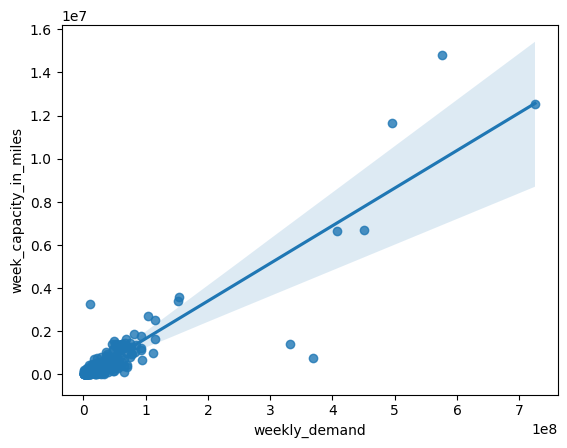

In [ ]:
import seaborn as sns
import numpy as np
columns = ['weekly_demand', 'week_capacity_in_miles']
Q1 = merged_data[columns].quantile(0.25)
Q3 = merged_data[columns].quantile(0.75)
IQR = Q3 - Q1

# Align the DataFrame explicitly
merged_data, Q1 = merged_data.align(Q1, axis=1, copy=False)
merged_data, Q3 = merged_data.align(Q3, axis=1, copy=False)

# Remove outliers
df_no_outliers = merged_data[~((merged_data < (Q1 - 1.5 * IQR)) | (merged_data > (Q3 + 1.5 * IQR))).any(axis=1)]
sns.regplot(data=merged_data, x='weekly_demand', y='week_capacity_in_miles')

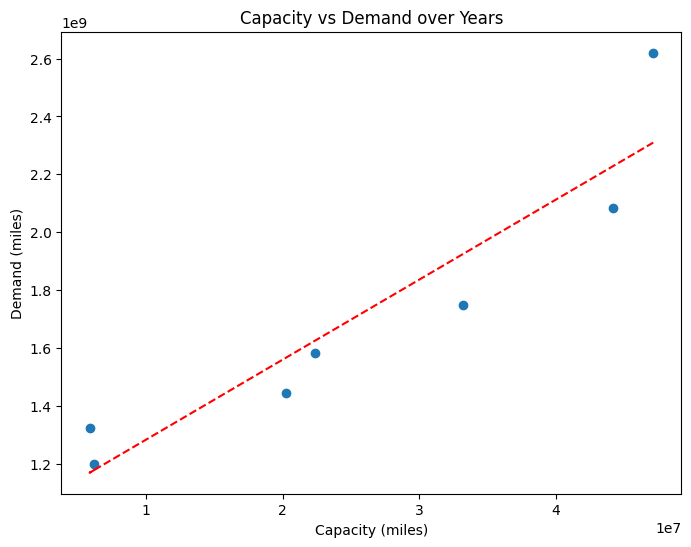

In [ ]:
# Group the data by year and calculate the total capacity and demand
grouped = merged_data.groupby('Year')[['week_capacity_in_miles', 'weekly_demand']].sum().reset_index()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the scatter plot
ax.scatter(grouped['week_capacity_in_miles'], grouped['weekly_demand'])

# Add labels and title
ax.set_xlabel('Capacity (miles)')
ax.set_ylabel('Demand (miles)')
ax.set_title('Capacity vs Demand over Years')

# Add a trendline
z = np.polyfit(grouped['week_capacity_in_miles'], grouped['weekly_demand'], 1)
p = np.poly1d(z)
ax.plot(grouped['week_capacity_in_miles'], p(grouped['week_capacity_in_miles']), color='r', linestyle='--')

# Show the plot
plt.show()

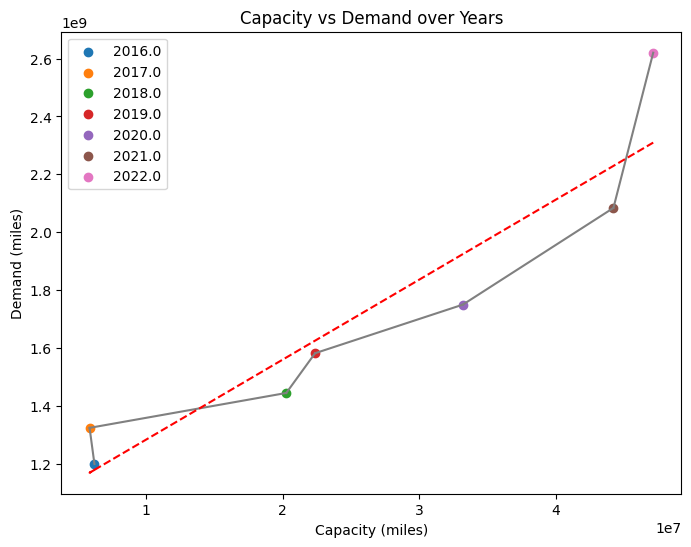

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by year and calculate the total capacity and demand
grouped = merged_data.groupby('Year')[['week_capacity_in_miles', 'weekly_demand']].sum().reset_index()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the connected scatterplot
for i in range(len(grouped)):
    ax.scatter(grouped['week_capacity_in_miles'][i], grouped['weekly_demand'][i], label=grouped['Year'][i])
    if i > 0:
        ax.plot([grouped['week_capacity_in_miles'][i-1], grouped['week_capacity_in_miles'][i]],
               [grouped['weekly_demand'][i-1], grouped['weekly_demand'][i]], color='gray', linestyle='-')

# Add labels and title
ax.set_xlabel('Capacity (miles)')
ax.set_ylabel('Demand (miles)')
ax.set_title('Capacity vs Demand over Years')
ax.legend()

# Add a trendline
z = np.polyfit(grouped['week_capacity_in_miles'], grouped['weekly_demand'], 1)
p = np.poly1d(z)
ax.plot(grouped['week_capacity_in_miles'], p(grouped['week_capacity_in_miles']), color='r', linestyle='--')

# Show the plot
plt.show()

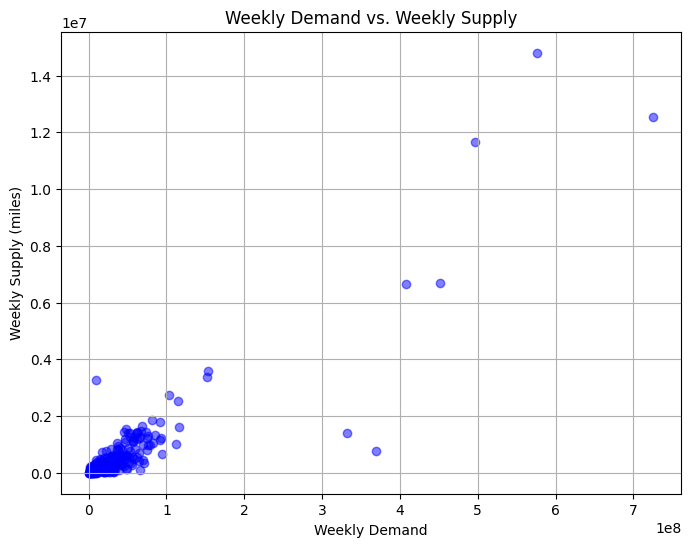

In [ ]:
import matplotlib.pyplot as plt

# Assuming merged_data has been defined previously

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_data['weekly_demand'], merged_data['week_capacity_in_miles'], color='blue', alpha=0.5)
plt.title('Weekly Demand vs. Weekly Supply')
plt.xlabel('Weekly Demand')
plt.ylabel('Weekly Supply (miles)')
plt.grid(True)
plt.show()


In [ ]:
# Assuming df_vehicles_per_state and df_charging_stations_per_state have been defined previously

# Join the two DataFrames on 'Year' and 'State'
merged_df = pd.merge(df_vehicles_per_state[['Year', 'State', 'Total_electric', 'weekly_demand']],
                     df_charging_stations_per_state[['week_capacity_in_miles', 'Year', 'State']],
                     on=['Year', 'State'], how='outer')

# Calculate totals
merged_df['total_week_demand'] = merged_df['weekly_demand']
merged_df['total_Total_electric'] = merged_df['Total_electric']
merged_df['total_weekly_capacity_in_miles'] = merged_df['week_capacity_in_miles'].sum()

# Assuming merged_df has been defined previously

# Get unique records
unique_records = merged_df.drop_duplicates(subset=['Year', 'State'])

unique_records



,Year,State,Total_electric,weekly_demand,week_capacity_in_miles,total_week_demand,total_Total_electric,total_weekly_capacity_in_miles
0,2021.0,Alaska,8600.0,2580000.0,450.0,2580000.0,8600.0,289758492.0
15,2021.0,Arkansas,28500.0,8550000.0,900.0,8550000.0,28500.0,289758492.0
63,2021.0,Connecticut,68700.0,20610000.0,900.0,20610000.0,68700.0,289758492.0
119,2021.0,Delaware,19700.0,5910000.0,43200.0,5910000.0,19700.0,289758492.0
170,2021.0,District of Columbia,19800.0,5940000.0,900.0,5940000.0,19800.0,289758492.0
...,...,...,...,...,...,...,...,...
137281,NaN,Minnesota,NaN,NaN,5400.0,NaN,NaN,289758492.0
137282,NaN,Oregon,NaN,NaN,3600.0,NaN,NaN,289758492.0
137283,2024.0,Kentucky,NaN,NaN,10800.0,NaN,NaN,289758492.0
137295,2024.0,Wyoming,NaN,NaN,5400.0,NaN,NaN,289758492.0


In [ ]:
# Group by 'Year' and 'State' and calculate the size of charging stations
miles_stations_per_year_per_state = df_charging_stations_per_state.groupby(['Year', 'State']).size().reset_index(name='Size_of_charging_stations')

# Perform an outer merge between the two DataFrames
merged_df = pd.merge(df_vehicles_per_state[['State', 'Total_electric', 'Year']], stations_per_year_per_state, on=['Year', 'State'], how='outer')

# Fill NaN values with 0
merged_df['Size_of_charging_stations'].fillna(0, inplace=True)
merged_df['Total_electric'].fillna(0, inplace=True)
merged_df['Size_of_charging_stations'].fillna(0, inplace=True)
merged_df[merged_df['State'] == 'California']
merged_df.to_csv('year_state_charging_reg.csv')